# VideoMAE Reconstruction

This notebook demonstrates the reconstructions of videos, predicted by our **VideoMAE** pre-trained with a certain masking ratio.

In [1]:
import sys, os
import warnings
warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import numpy as np
from einops import rearrange
from decord import VideoReader
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import tensorflow as tf
sys.path.append(os.path.dirname(os.getcwd()))

**utility**

In [2]:
IMAGENET_MEAN = np.array([0.45, 0.45, 0.45])
IMAGENET_STD = np.array([0.225, 0.225, 0.225])

def show_sequence(seq, sample=8, title=''):
    '''Plot a sequence of images horizontally'''
    # clip is [T, H, W, 3]
    assert (seq.shape[-1] == 3)
    fig = plt.figure(figsize=(20, 2.5))
    fig.suptitle(title, fontsize=16)
    grid = ImageGrid(fig, 111, nrows_ncols=(1, sample), axes_pad=0.1)
    for ax, img in zip(grid, seq):
        img = img * IMAGENET_STD + IMAGENET_MEAN
        ax.imshow(
            (img * 255).clip(0, 255).astype('uint8')
        )
        ax.set_axis_off()
    plt.show()
    return

**data process**

In [3]:
num_frames = 16
input_size = 224
patch_size = (16, 16)

def format_frames(frame, output_size):
    frame = tf.image.convert_image_dtype(frame, tf.uint8)
    frame = tf.image.resize(frame, size=output_size)
    frame = frame / 255.
    frame = frame - IMAGENET_MEAN
    frame = frame / IMAGENET_STD
    return frame

def read_video(file_path):
    container = VideoReader(file_path)
    return container

def frame_sampling(container, num_frames):
    interval = len(container) // num_frames
    bids = np.arange(num_frames) * interval
    offset = np.random.randint(interval, size=bids.shape)
    frame_index = bids + offset
    frames = container.get_batch(frame_index).asnumpy()
    frames = np.stack(frames)
    frames = format_frames(frames, [input_size] * 2)
    return frames

In [4]:
# a sample video from kinetics-400 test set.
container = read_video('0N8szFGAmMw.mp4')
frames = frame_sampling(container, num_frames=num_frames)
frames.shape

TensorShape([16, 224, 224, 3])

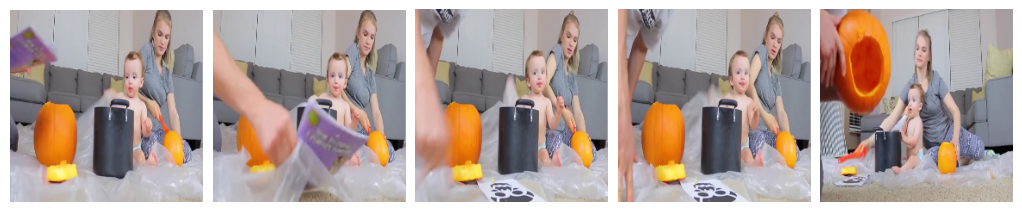

In [5]:
show_sequence(frames.numpy()[::-1], sample=5)

## Model [masked autoencoder]

In [6]:
from videomae import VideoMAE_ViTS16PT
from videomae.layers.masking_generator import TubeMaskingGenerator

In [7]:
window_size = (
    num_frames // 2, 
    input_size // patch_size[0], 
    input_size // patch_size[1]
)
print(window_size)

(8, 14, 14)


In [8]:
tube_mask = TubeMaskingGenerator(
    input_size=window_size, 
    mask_ratio=0.70
)
make_bool = tube_mask()
make_bool

array([1., 1., 1., ..., 0., 0., 0.])

In [9]:
bool_masked_pos_tf = tf.constant(make_bool, dtype=tf.int32)
bool_masked_pos_tf = tf.expand_dims(bool_masked_pos_tf, axis=0)
bool_masked_pos_tf = tf.cast(bool_masked_pos_tf, tf.bool)
bool_masked_pos_tf

<tf.Tensor: shape=(1, 1568), dtype=bool, numpy=array([[ True,  True,  True, ..., False, False, False]])>

In [10]:
model = VideoMAE_ViTS16PT()
model.load_weights("TFVideoMAE_S_16x224_PT")

orig_frames = frames[None, ...]
pred_tf = model(orig_frames, bool_masked_pos_tf, training=False)
pred_tf.shape

TensorShape([1, 1096, 1536])

In [11]:
model.summary(line_length=70)

Model: "TFVideoMAE_S_16x224_PT"
______________________________________________________________________
 Layer (type)                  Output Shape                Param #    
 TFPretrainVisionTransformerE  multiple                    21879936   
 ncoder (TFPretrainVisionTran                                         
 sformerEncoder)                                                      
                                                                      
 TFPretrainVisionTransformerD  multiple                    2075520    
 ecoder (TFPretrainVisionTran                                         
 sformerDecoder)                                                      
                                                                      
 encoder_to_decoder (Dense)    multiple                    73728      
                                                                      
Total params: 24029376 (91.66 MB)
Trainable params: 24029376 (91.66 MB)
Non-trainable params: 0 (0.00 Byte)
________

In [12]:
img_squeeze = rearrange(
    orig_frames.numpy(), 
    'b (t p0) (h p1) (w p2) c -> b (t h w) (p0 p1 p2) c', 
    p0=2, p1=patch_size[0], p2=patch_size[0]
)
img_mean = np.mean(img_squeeze, axis=-2, keepdims=True)
img_variance = np.var(img_squeeze, axis=-2, ddof=1, keepdims=True)
img_norm = (img_squeeze - img_mean) / (np.sqrt(img_variance) + 1e-6)
img_norm.shape

(1, 1568, 512, 3)

In [13]:
img_patch = rearrange(img_norm, 'b n p c -> b n (p c)')
img_patch[bool_masked_pos_tf] = pred_tf
img_patch.shape

(1, 1568, 1536)

In [14]:
# make mask
mask = np.ones_like(img_patch)
mask[bool_masked_pos_tf] = 0
mask = rearrange(
    mask, 'b n (p c) -> b n p c', c=3
)
mask = rearrange(
    mask, 
    'b (t h w) (p0 p1 p2) c -> b (t p0) (h p1) (w p2) c',
    p0=2, p1=patch_size[0], p2=patch_size[1], h=14, w=14
)
mask.shape

(1, 16, 224, 224, 3)

In [15]:
#save reconstruction video
rec_img = rearrange(img_patch, 'b n (p c) -> b n p c', c=3)

# Notice: To visualize the reconstruction video, 
# we add the predict and the original mean and var of each patch.
img_mean = np.mean(img_squeeze, axis=-2, keepdims=True)
img_std = np.sqrt(np.var(img_squeeze, axis=-2, ddof=1, keepdims=True) + 1e-6) 
rec_img = rec_img * img_std + img_mean

rec_img = rearrange(
    rec_img, 
    'b (t h w) (p0 p1 p2) c -> b (t p0) (h p1) (w p2) c', 
    p0=2, p1=patch_size[0], p2=patch_size[1], h=14, w=14
)
rec_img.shape

(1, 16, 224, 224, 3)

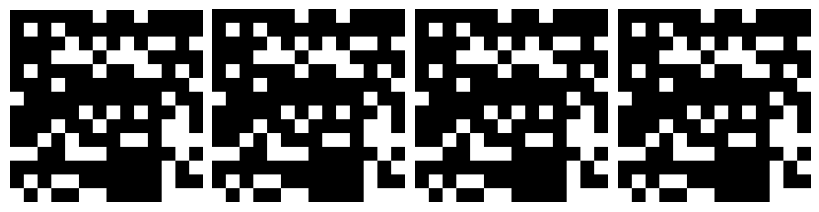

In [19]:
mask_scale = mask[0]
mask_scale = mask_scale - IMAGENET_MEAN
mask_scale = mask_scale / IMAGENET_STD
show_sequence(mask_scale[::-1], sample=4)

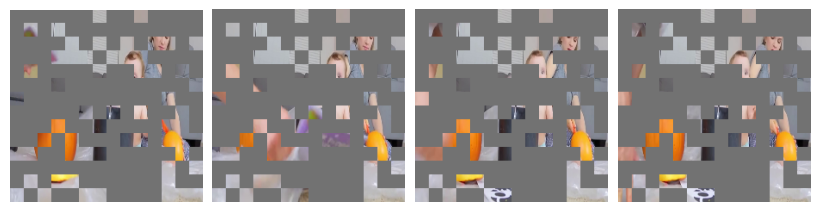

In [20]:
show_sequence(mask[0] * frames.numpy()[::-1], sample=4)

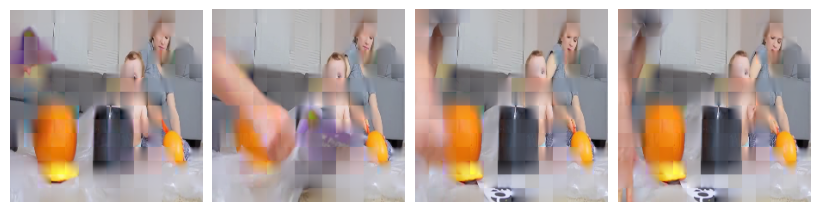

In [21]:
show_sequence(rec_img[0][::-1], sample=4)